# Deep Learning & Art: Neural Style Transfer

## Table of Contents

- [1 - Packages](#1)
- [2 - Problem Statement](#2)
- [3 - Transfer Learning](#3)
- [4 - Neural Style Transfer (NST)](#4)
    - [4.1 - Computing the Content Cost](#4-1)
            - [Excercise 1 - compute_content_cost](#ex-1)
    - [4.2 - Computing the Style Cost](#4-2)
        - [4.2.1 - Style Matrix](#4-2-1)
            - [Gram_matrix](#ex-2)
        - [4.2.2 - Style Cost](#4-2-2)
            - [Compute_layer_style_cost](#ex-3)
        - [4.2.3 Style Weights](#4-2-3)
            - [Compute_style_cost](#4)
    - [4.3 - Defining the Total Cost to Optimize](#4-3)
        - [Exercise 5 - total_cost](#5)
- [5 - Solving the Optimization Problem](#5)
    - [5.1 Load the Content Image](#5-1)
    - [5.2 Load the Style Image](#5-2)
    - [5.3 Randomly Initialize the Image to be Generated](#5-3)
    - [5.4 - Load Pre-trained VGG19 Model](#5-4)
    - [5.5 - Compute Total Cost](#5-5)
        - [5.5.1 - Compute Content Cost](#5-5-1)
        - [5.5.2 - Compute Style Cost](#5-5-2)
            - [Train_step](#6)
    - [5.6 - Train the Model](#5-6)
- [6 - Test With Your Own Image (Optional/Ungraded)](#6)
- [7 - References](#7)




<a name='1'></a>
## 1 - Packages

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint
%matplotlib inline

<a name='3'></a>
## 3 - Transfer Learning

We will be using the the epynomously named VGG network from the [original NST paper](https://arxiv.org/abs/1508.06576) published by the Visual Geometry Group at University of Oxford in 2014. Specifically, you'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [2]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


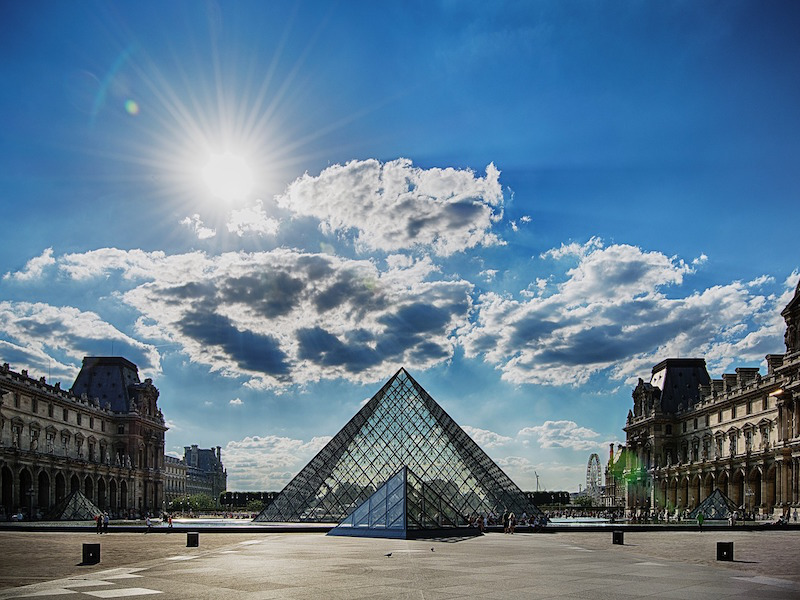

In [3]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

In [4]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieving dimensions from a_G
    m, n_H, n_W, n_C = a_G.shape
    
    new_shape = [int(m), int(n_H * n_W), int(n_C)]
    
    # Reshaping
    a_C_unrolled = tf.reshape(a_C, new_shape)
    a_G_unrolled = tf.reshape(a_G, new_shape)
    
    # compute the cost
    J_content = (.25 / float(int(n_H * n_W * n_C))) * tf.reduce_sum(tf.square(a_G_unrolled - a_C_unrolled))
    
    return J_content

In [5]:
tf.random.set_seed(1)
a_C = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
a_G = tf.random.normal([1, 1, 4, 4, 3], mean=1, stddev=4)
J_content = compute_content_cost(a_C, a_G)
J_content_0 = compute_content_cost(a_C, a_C)
assert type(J_content) == EagerTensor, "Use the tensorflow function"
assert np.isclose(J_content_0, 0.0), "Wrong value. compute_content_cost(A, A) must be 0"
assert np.isclose(J_content, 7.0568767), f"Wrong value. Expected {7.0568767},  current{J_content}"

print("J_content = " + str(J_content))

# Is it working with symbolic tensors
ll = tf.keras.layers.Dense(8, activation='relu', input_shape=(1, 4, 4, 3))
model_tmp = tf.keras.models.Sequential()
model_tmp.add(ll)
try:
    compute_content_cost(ll.output, ll.output)
    print("\033[92mAll tests passed")
except Exception as inst:
    print("\n\033[91mDon't use the numpy API inside compute_content_cost\n")
    print(inst)

J_content = tf.Tensor(7.056877, shape=(), dtype=float32)
All tests passed


<a name='4-2'></a>
### 4.2 - Computing the Style Cost

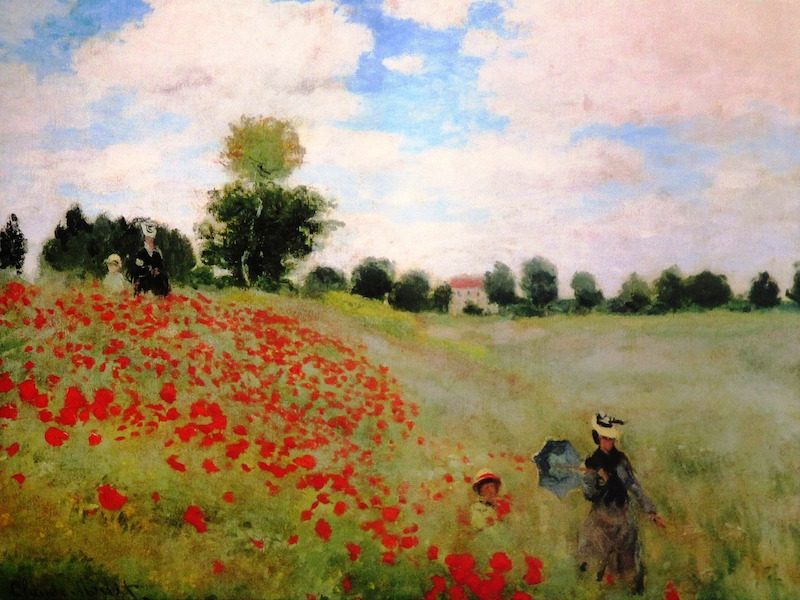

In [6]:
example = Image.open("images/monet_800600.jpg")
example

<a name='2'></a>
### Gram_matrix

In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    GA = tf.matmul(A,tf.transpose(A))
    return GA

In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshaping the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, [n_H * n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = (.5 / (n_H * n_W * n_C)) ** 2 * tf.reduce_sum(tf.square(GS - GG))
    #J_style_layer = None
    
    return J_style_layer

<a name='4-2-3'></a>
#### 4.2.3 Style Weights

Layer names:

In [11]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
vgg.get_layer('block5_conv4').output

<tf.Tensor 'block5_conv4/Relu:0' shape=(None, 25, 25, 512) dtype=float32>

Now choose layers to represent the style of the image and assign style costs:

In [13]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

<a name='4'></a>
### Compute_style_cost

In [14]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """ 
    # the overall style cost
    J_style = 0
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style

<a name='4-3'></a>
### 4.3 - Defining the Total Cost to Optimize

In [15]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha * J_content + beta * J_style

    return J

<a name='5-1'></a>
### 5.1 Load the Content Image

(1, 400, 400, 3)


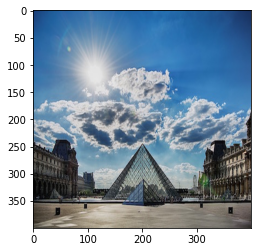

In [17]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### 5.2 Load the Style Image
Now load, reshape and normalize your "style" image (Claude Monet's painting):

(1, 400, 400, 3)


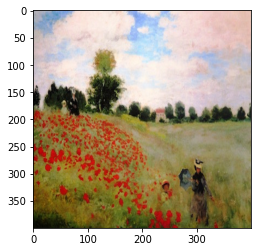

In [18]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### 5.3 Randomly Initialize the Image to be Generated
Now, you get to initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

(1, 400, 400, 3)


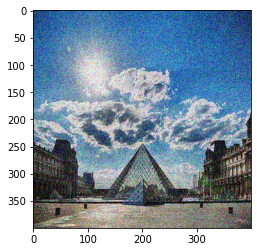

In [19]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## 5.4 - Load Pre-trained VGG19 Model

In [20]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

Defining the content layer and build the model.

In [21]:
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

Save the outputs for the content and style layers in separate variables.

In [22]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style enconder

<a name='5-5'></a>
### 5.5 - Compute Total Cost

In [23]:
# Assigning the content image to be the input of the VGG model.  
# Setting a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### 5.5.2 - Compute the Style image Encoding (a_S) 

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [24]:
# Assigning the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that we will need to display the images generated by the style transfer model.

In [25]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='6'></a>
### Train_step 

Implementing the train_step() function for transfer learning

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function we must use the precomputed encoded images a_S and a_C
        
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        
        # style cost
        J_style = compute_style_cost(a_S, a_G)

        # content cost
        J_content = compute_content_cost(a_C, a_G)
        # total cost
        J = total_cost(J_content, J_style)  
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

<a name='5-6'></a>
### 5.6 - Train the Model

Run the following cell to generate an artistic image. It should take about 3min on a GPU for 2500 iterations. Neural Style Transfer is generally trained using GPUs.

If you increase the learning rate you can speed up the style transfer, but often at the cost of quality.

Epoch 0 


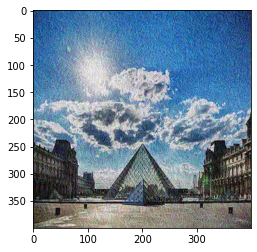

Epoch 250 


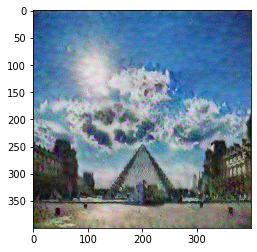

Epoch 500 


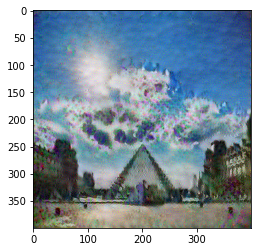

Epoch 750 


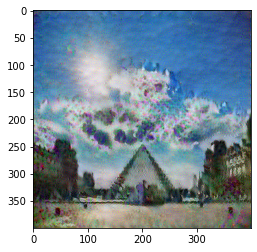

Epoch 1000 


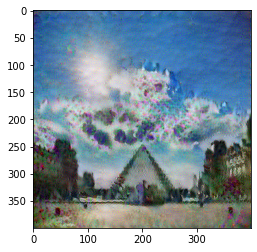

Epoch 1250 


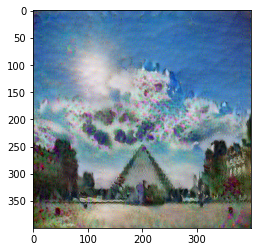

Epoch 1500 


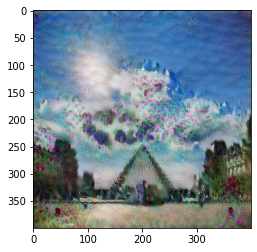

Epoch 1750 


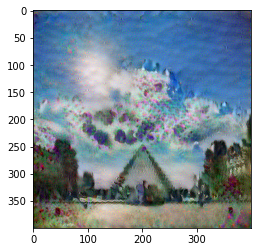

Epoch 2000 


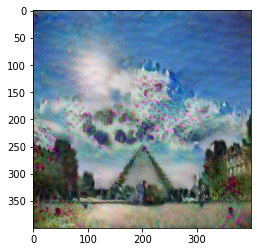

Epoch 2250 


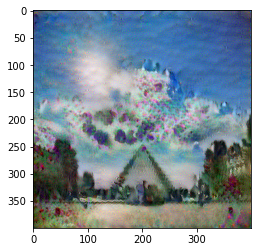

Epoch 2500 


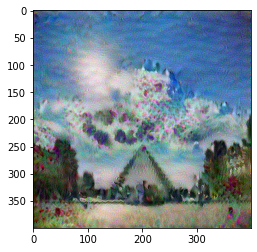

In [28]:
# Show the generated image at some epochs
# Uncoment to reset the style transfer process. You will need to compile the train_step function again 
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

Now, run the following code cell to see the results!

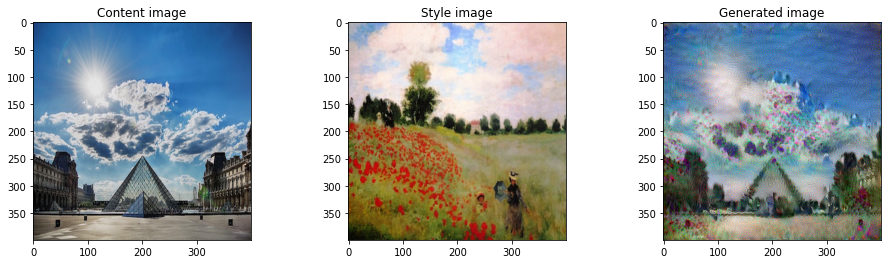

In [29]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()